In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

In [2]:
!pip install segmentation-models-pytorch --quiet
!pip install -U albumentations --quiet 

     |████████████████████████████████| 88 kB 4.1 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 376 kB 34.3 MB/s 
     |████████████████████████████████| 102 kB 7.2 MB/s 
     |████████████████████████████████| 48.3 MB 1.7 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DIR_train = "/content/drive/MyDrive/Colab Notebooks/AI_final_proj/Train_Images/"  #training
DATA_DIR_mask = "/content/drive/MyDrive/Colab Notebooks/AI_final_proj/Train_Masks/" #training
# DATA_DIR_vail = '/data/home/VGH_Seg_IMG_Label/Valid'
# DATA_DIR_test = '/data/home/VGH_Seg_IMG_Label/Test'
SavePath = "/content/drive/MyDrive/Colab Notebooks/AI_final_proj"

In [5]:
RESIZE_SIZE = 32*25
BATCH_SIZE = 4

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'
EPOCHS = 50

In [6]:
# x_train_dir = os.path.join(DATA_DIR_train, 'img')
# y_train_dir = os.path.join(DATA_DIR_train,'label')

# x_valid_dir = os.path.join(DATA_DIR_vail, 'img')
# y_valid_dir = os.path.join(DATA_DIR_vail, 'label')

# x_test_dir = os.path.join(DATA_DIR_test, 'img')
# y_test_dir = os.path.join(DATA_DIR_test,'label')

In [7]:
ids = os.listdir(DATA_DIR_train)
print(ids)
print(len(ids))

['00000091.jpg', '00000060.jpg', '00000040.jpg', '00000064.jpg', '00000113.jpg', '00000072.jpg', '00000047.jpg', '00000080.jpg', '00000094.jpg', '00000049.jpg', '00000057.jpg', '00000069.jpg', '00000115.jpg', '00000058.jpg', '00000056.jpg', '00000045.jpg', '00000102.jpg', '00000066.jpg', '00000095.jpg', '00000122.jpg', '00000101.jpg', '00000036.jpg', '00000077.jpg', '00000038.jpg', '00000109.jpg', '00000108.jpg', '00000097.jpg', '00000050.jpg', '00000119.jpg', '00000121.jpg', '00000041.jpg', '00000042.jpg', '00000075.jpg', '00000081.jpg', '00000076.jpg', '00000068.jpg', '00000039.jpg', '00000035.jpg', '00000093.jpg', '00000096.jpg', '00000043.jpg', '00000079.jpg', '00000110.jpg', '00000074.jpg', '00000061.jpg', '00000055.jpg', '00000062.jpg', '00000034.jpg', '00000112.jpg', '00000067.jpg', '00000071.jpg', '00000090.jpg', '00000059.jpg', '00000065.jpg', '00000106.jpg', '00000116.jpg', '00000082.jpg', '00000054.jpg', '00000092.jpg', '00000084.jpg', '00000070.jpg', '00000078.jpg', '000000

In [8]:
images_list = [os.path.join(DATA_DIR_train, image_id) for image_id in ids]
# display(images_list)
print(len(images_list))
masks_list = [os.path.join(DATA_DIR_mask, mask_id) for mask_id in ids]
# display(masks_list)
print(len(masks_list))

1053
1053


In [9]:
for i in range(len(masks_list)):
  masks_list[i] = masks_list[i].replace('.jpg','.png')
# display(masks_list)

In [10]:
from sklearn.model_selection import train_test_split


x_train, x_valid, y_train, y_valid = train_test_split(images_list, masks_list, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.1, random_state=21)


# trainset = dataset(xtrain, ytrain, train_transform)
# validset = dataset(xvalid, yvalid, valid_transform)
# testset = dataset(xtest, ytest, valid_transform)

# print(f'trainset: {len(train_dataset)}\nvalidset: {len(valid_dataset)}\ntestset: {len(test_dataset)}')

# idx = np.random.randint(len(train_dataset))
# print(f'{idx:5d}/{len(train_dataset)} : {train_dataset[idx]}')

In [11]:
print(len(x_train))
print(len(y_train))
print(len(x_valid))
print(len(y_valid))
print(len(x_test))
print(len(y_test))

737
737
284
284
32
32


In [12]:
y_train
# cv2.imread(x_train[0])
cv2.imread(y_train[0], 0)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch.nn.functional as F

In [15]:

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images_list, 
            masks_list, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        # self.ids = os.listdir(images_dir)
        # self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.images_fps = images_list
        self.masks_fps = masks_list
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        # self.masks_fps[i] = self.masks_fps[i].replace('.jpg','.png')
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape != (RESIZE_SIZE, RESIZE_SIZE, 3):
            image = cv2.resize(image, (RESIZE_SIZE, RESIZE_SIZE), interpolation=cv2.INTER_LANCZOS4)
        
        mask = cv2.imread(self.masks_fps[i], 0)
        if mask.shape != (RESIZE_SIZE, RESIZE_SIZE, 3):
            mask = cv2.resize(mask, (RESIZE_SIZE, RESIZE_SIZE), interpolation=cv2.INTER_LANCZOS4)  
        mask = mask.astype('bool')
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

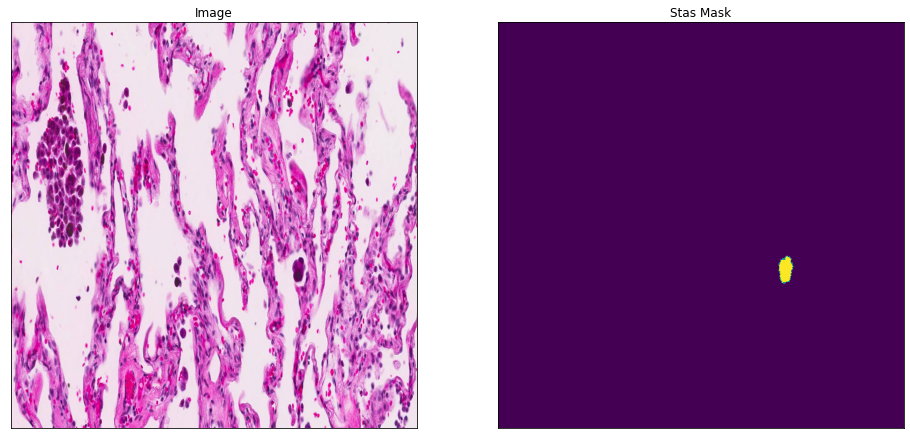

In [16]:
# Lets look at data we have

dataset = Dataset(images_list=images_list, 
                  masks_list=masks_list, 
                  classes=['stas'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    stas_mask=mask.squeeze(),
)

In [17]:
print(image.shape)
print(mask.shape)

(800, 800, 3)
(800, 800, 1)


In [18]:
mask.squeeze().shape

(800, 800)

In [19]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=40,p=1,border_mode=cv2.BORDER_CONSTANT),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        
        albu.HueSaturationValue(p=0.6),
        albu.Sharpen(p=0.5),
        albu.RandomBrightnessContrast(p=0.4),

        albu.Crop(x_min=0, y_min=0, x_max=RESIZE_SIZE, y_max=RESIZE_SIZE-40, p=0.5),
        albu.PadIfNeeded(RESIZE_SIZE, RESIZE_SIZE)

        
    ]
    return albu.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

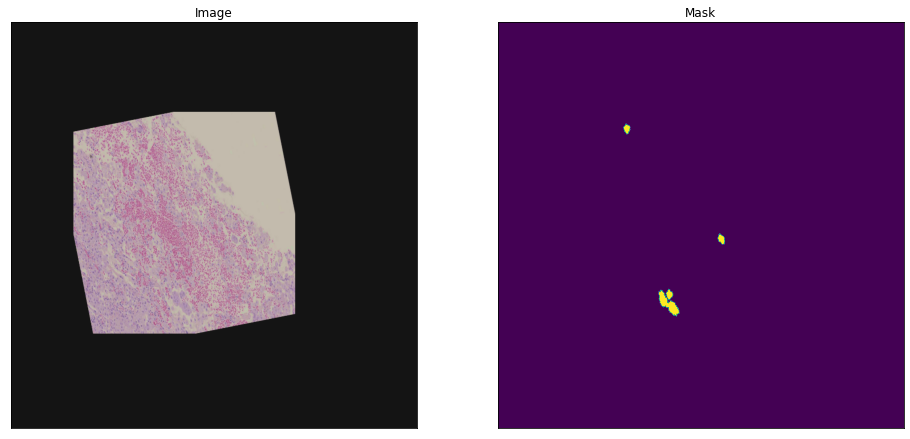

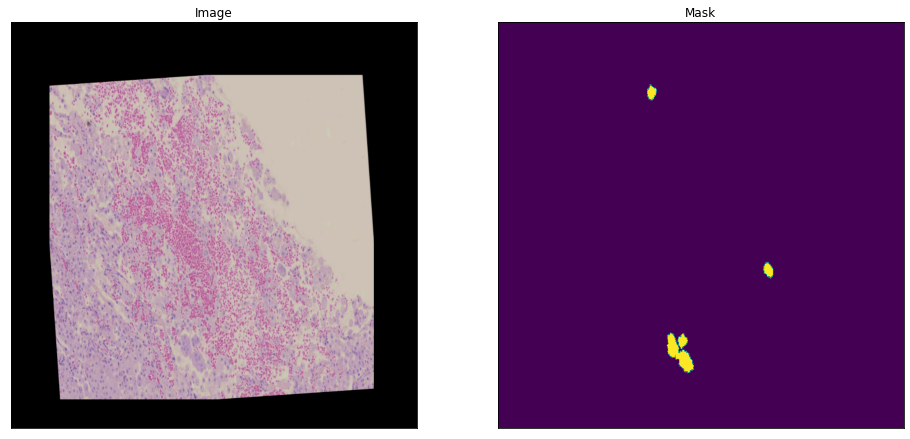

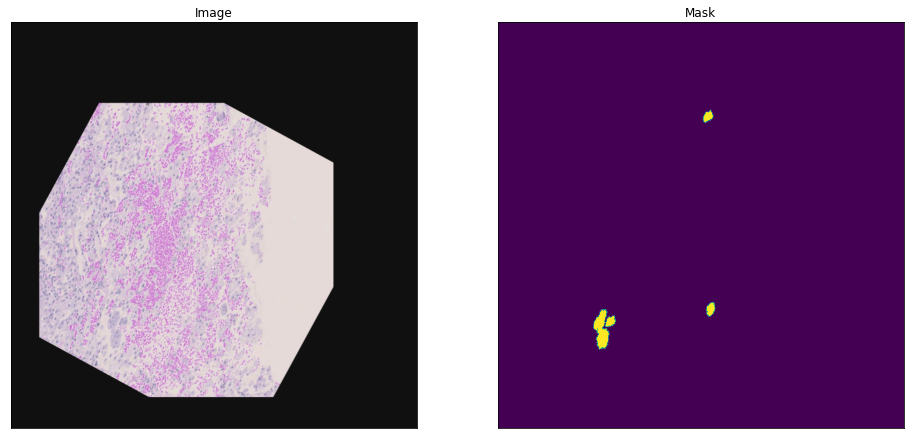

In [20]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    images_list=images_list, 
    masks_list=masks_list, 
    augmentation=get_training_augmentation(), 
    classes=['stas'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [21]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch import nn

In [22]:

# ENCODER = 'resnet50'
# ENCODER_WEIGHTS = 'imagenet'
# CLASSES = ['stas']
# ACTIVATION = 'sigmoid' 
# DEVICE = 'cuda'
# EPOCHS = 10



# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,

)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
# train_dataset = Dataset(
#     images_list=images_list, 
#     masks_list=masks_list,  
#     augmentation=get_training_augmentation(), 
#     preprocessing=get_preprocessing(preprocessing_fn),
#     classes=CLASSES,
# )

In [24]:
train_dataset = Dataset(
    x_train, 
    y_train, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid, 
    y_valid, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [25]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [26]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)



In [27]:
path = SavePath
# os.makedirs(path)

In [28]:
import gc
gc.collect()
torch.cuda.empty_cache()    

In [29]:
max_score = 0

train_loss_list = []
train_fscore_list = []
valid_loss_list = []
valid_fscore_list = []

for i in range(EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_loss_list.append(train_logs['dice_loss'])
    train_fscore_list.append(train_logs['fscore'])
    
    valid_loss_list.append(valid_logs['dice_loss'])
    valid_fscore_list.append(valid_logs['fscore'])
    

    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, path+'/example_best_mode_unet_resnet50_aug.pth')
        print('Model saved!')

        
    if i == 35:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 71/71 [00:46<00:00,  1.54it/s, dice_loss - 0.8404, fscore - 0.3936]
Model saved!

Epoch: 1
valid: 100%|██████████| 71/71 [00:29<00:00,  2.41it/s, dice_loss - 0.6458, fscore - 0.554]
Model saved!

Epoch: 2
valid: 100%|██████████| 71/71 [00:29<00:00,  2.41it/s, dice_loss - 0.506, fscore - 0.5732]
Model saved!

Epoch: 3
valid: 100%|██████████| 71/71 [00:29<00:00,  2.44it/s, dice_loss - 0.5308, fscore - 0.4916]

Epoch: 4
valid: 100%|██████████| 71/71 [00:30<00:00,  2.34it/s, dice_loss - 0.3123, fscore - 0.7207]
Model saved!

Epoch: 5
valid: 100%|██████████| 71/71 [00:28<00:00,  2.46it/s, dice_loss - 0.3429, fscore - 0.6727]

Epoch: 6
valid: 100%|██████████| 71/71 [00:28<00:00,  2.46it/s, dice_loss - 0.3499, fscore - 0.6609]

Epoch: 7
valid: 100%|██████████| 71/71 [00:28<00:00,  2.45it/s, dice_loss - 0.2689, fscore - 0.7402]
Model saved!

Epoch: 8
valid: 100%|██████████| 71/71 [00:29<00:00,  2.44it/s, dice_loss - 0.2347, fscore - 0.7747]
Model saved!

Epoch

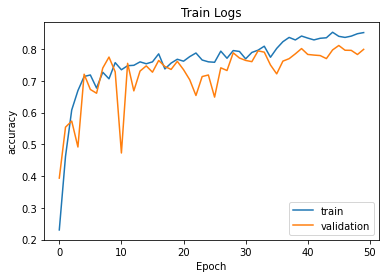

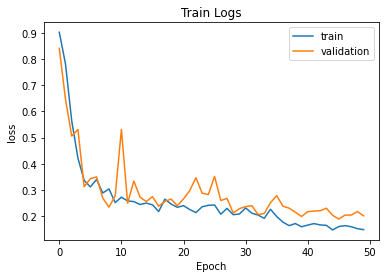

In [30]:
plt.figure(0)
plt.plot(train_fscore_list)
plt.plot(valid_fscore_list)
plt.title('Train Logs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.figure(1)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Train Logs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')


plt.show()

In [31]:
# load best saved checkpoint
best_model = torch.load(SavePath +'/'+'example_best_mode_unet_resnet50_aug.pth')

In [32]:
test_dataset = Dataset(
    x_test, 
    y_test, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

In [33]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 32/32 [00:05<00:00,  5.59it/s, dice_loss - 0.1503, fscore - 0.8505]


In [34]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test, y_test, 
    classes=CLASSES,
)

In [35]:
out_path= SavePath + "/" + "out_dir"
# os.makedirs(out_path)

00000009.png


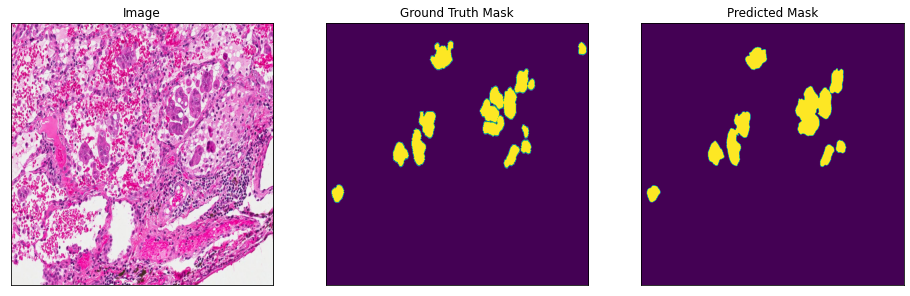

00000438.png


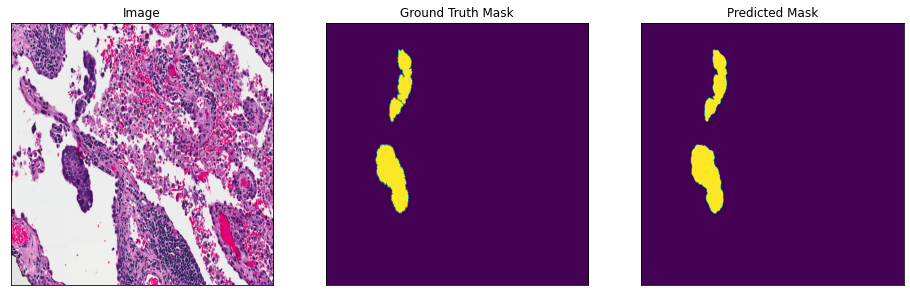

00000183.png


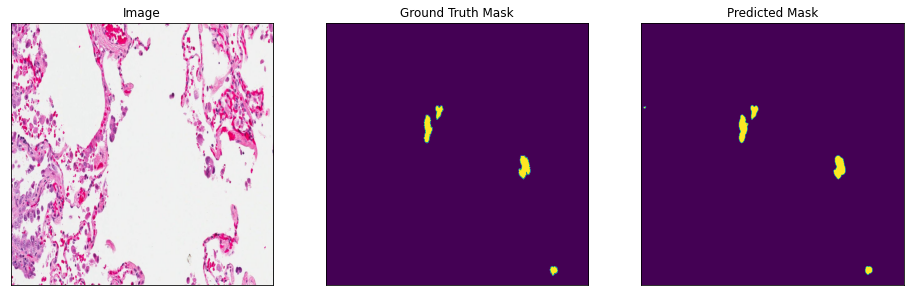

00000527.png


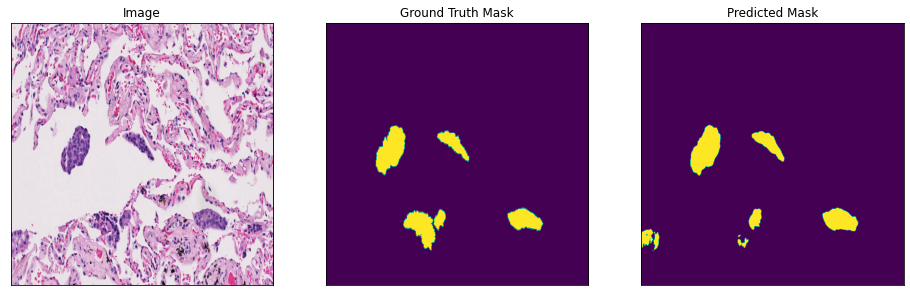

00000254.png


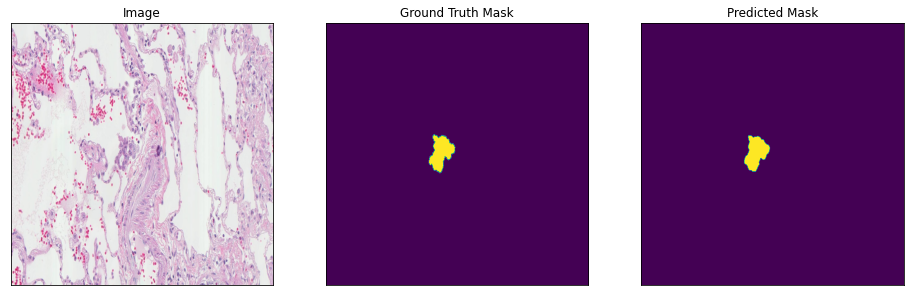

00000489.png


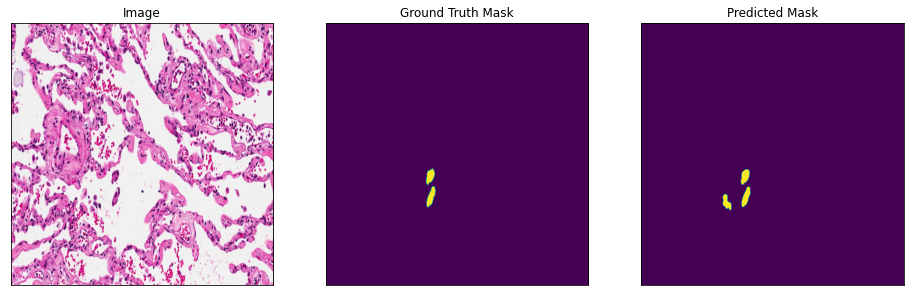

00000702.png


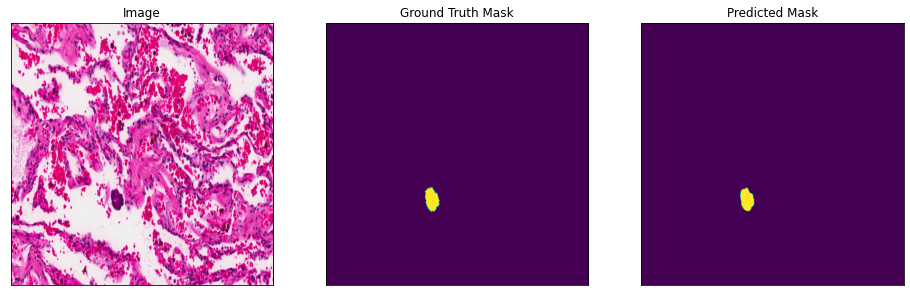

00000591.png


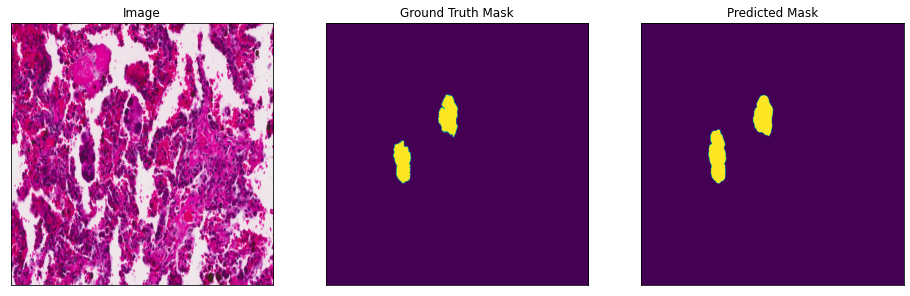

00000256.png


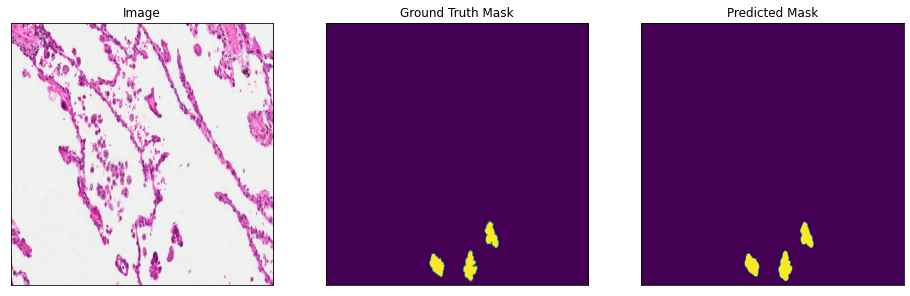

00000376.png


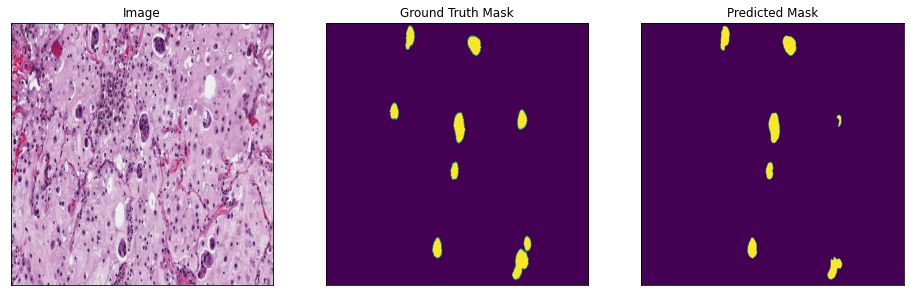

00000092.png


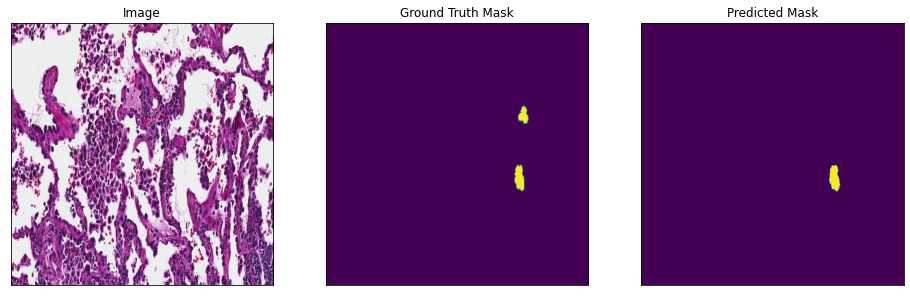

00000168.png


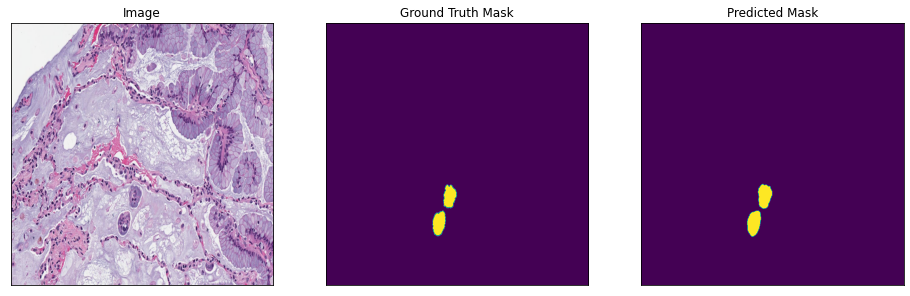

00000593.png


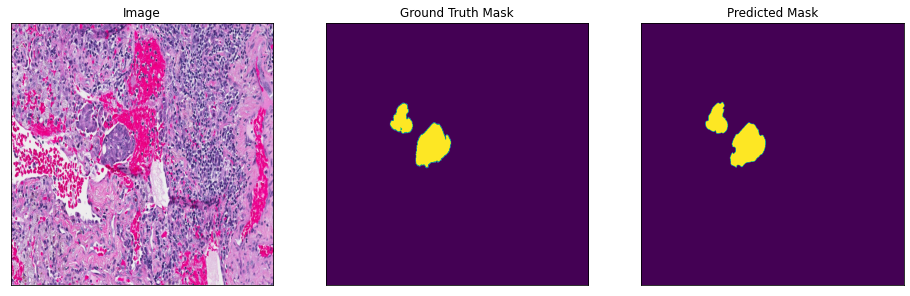

00000224.png


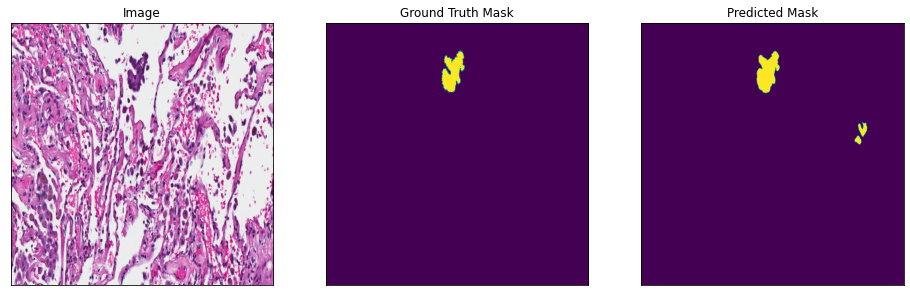

00000990.png


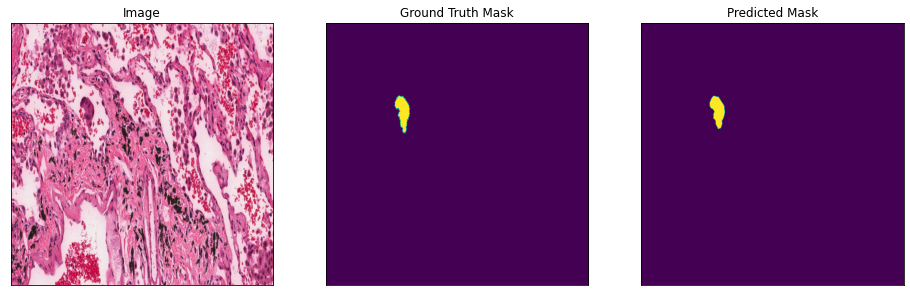

00000620.png


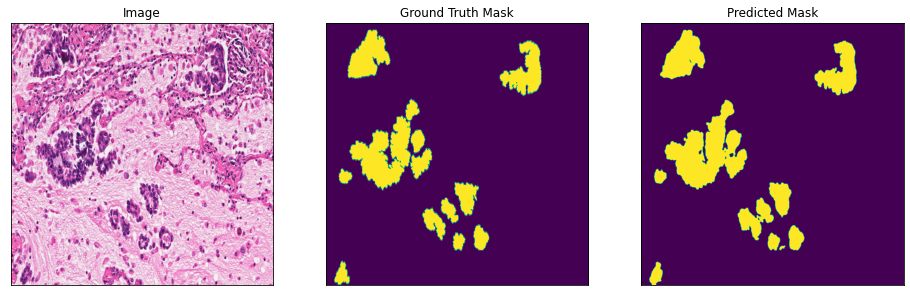

00000432.png


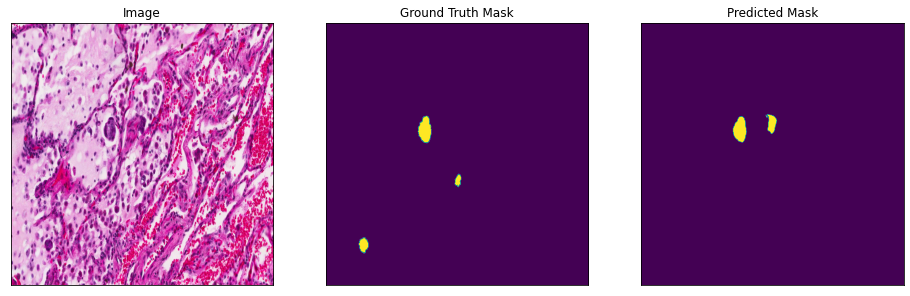

00000717.png


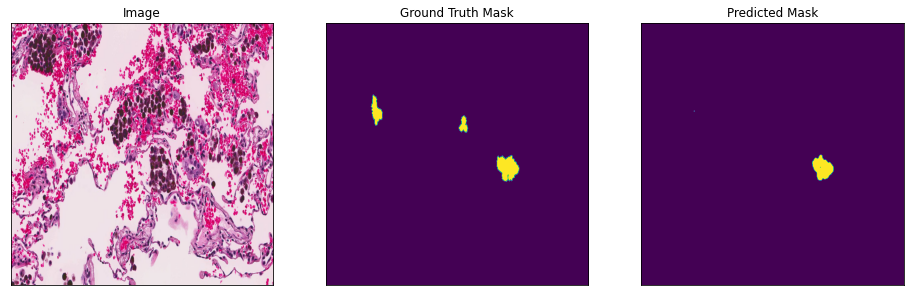

00000084.png


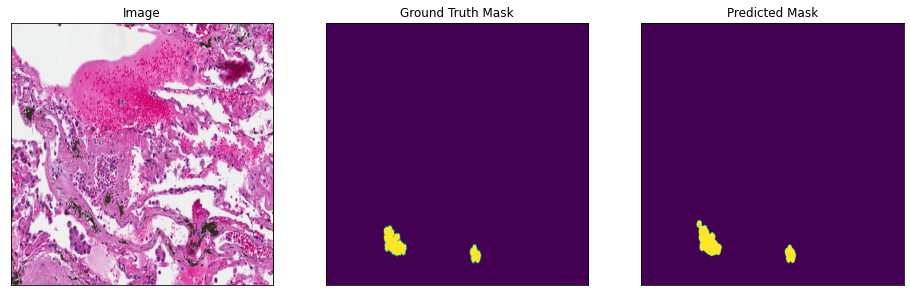

00000960.png


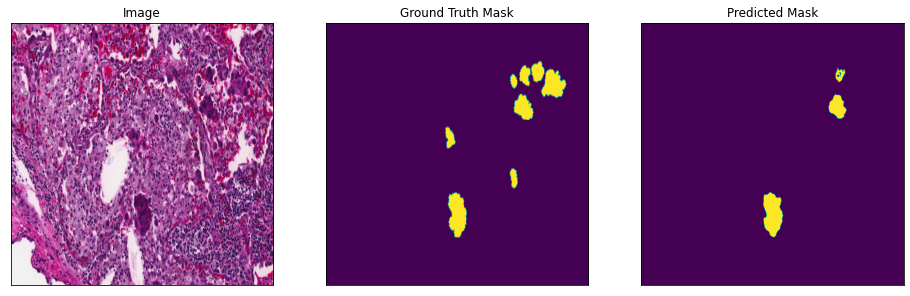

00000793.png


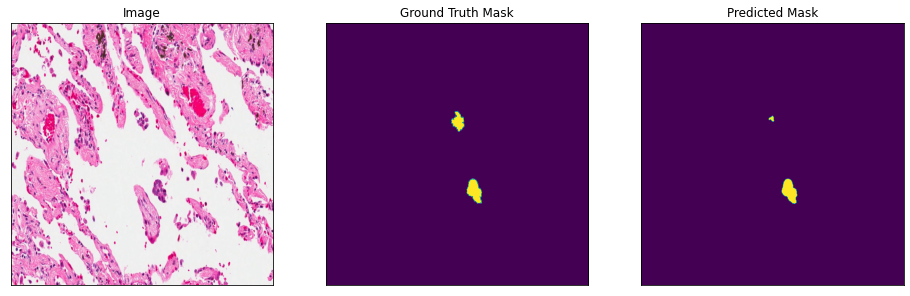

00000838.png


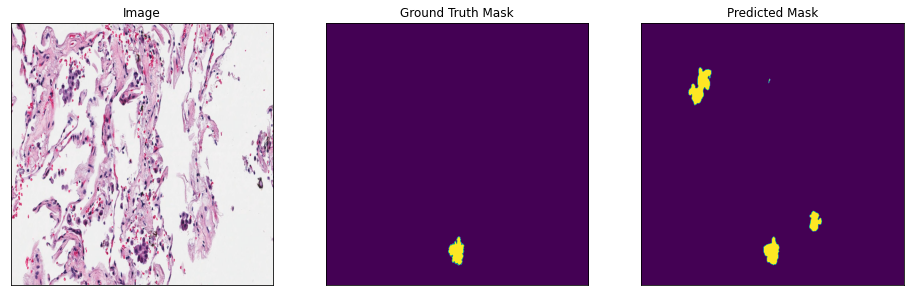

00000983.png


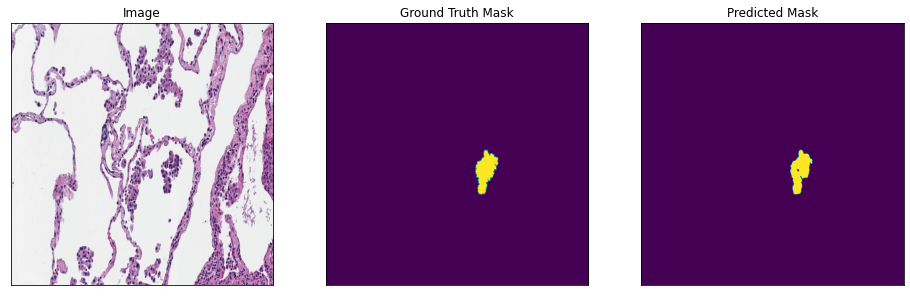

00000482.png


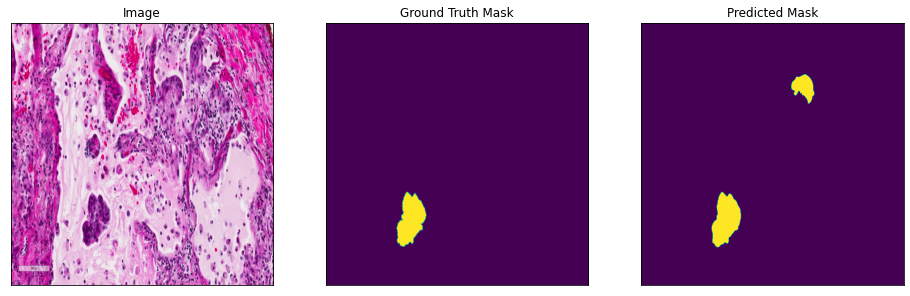

00001050.png


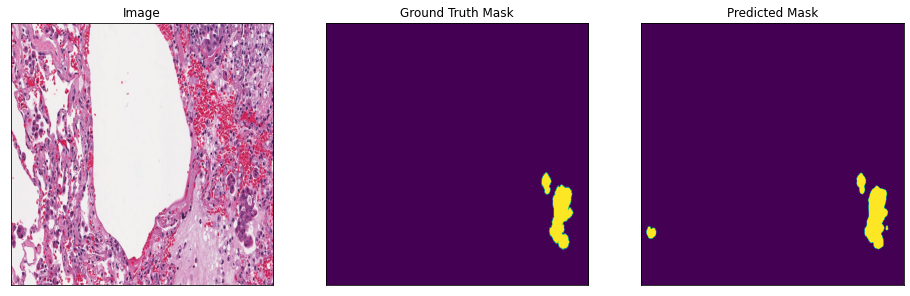

00000561.png


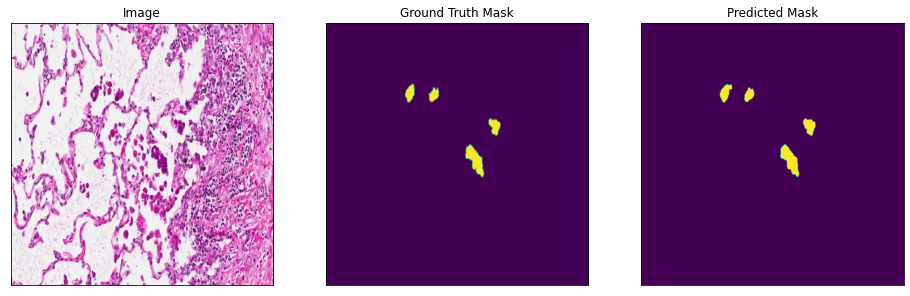

00000041.png


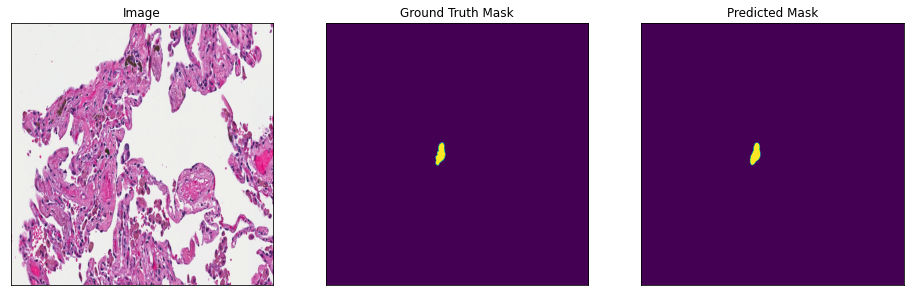

00000588.png


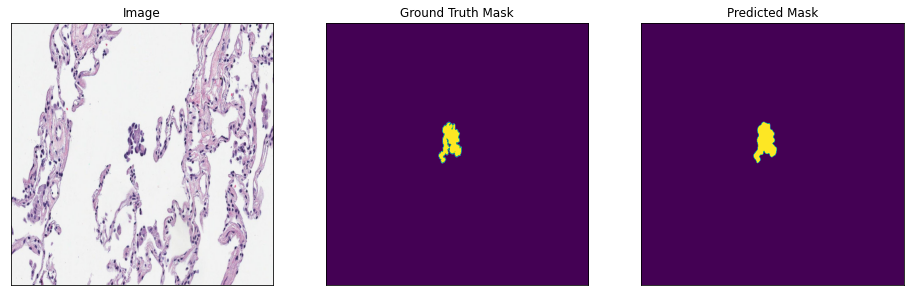

00000372.png


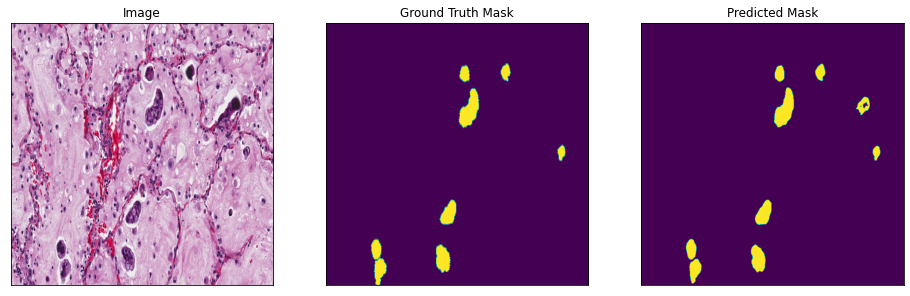

00000819.png


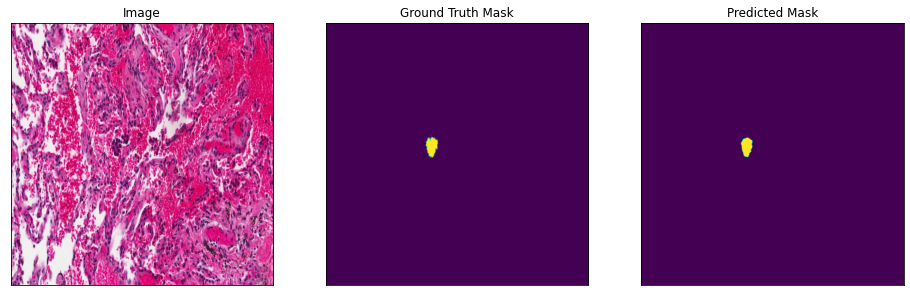

00000651.png


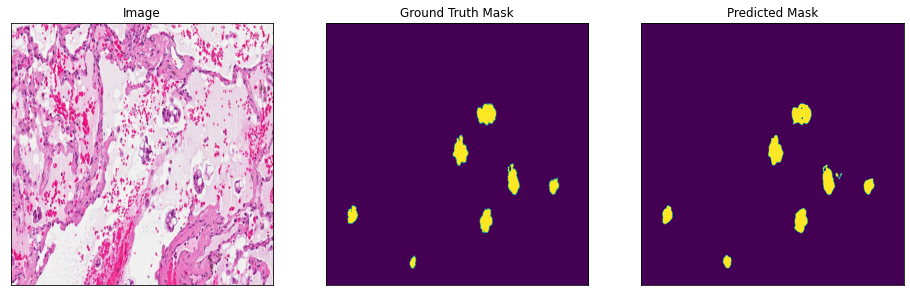

00000046.png


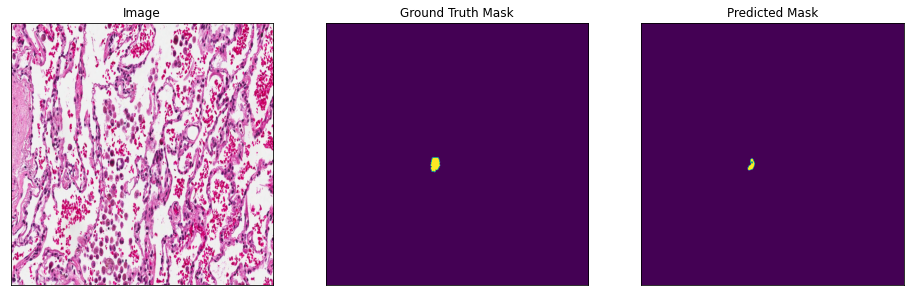

In [36]:

for i in range(len(test_dataset_vis)):
    name = os.path.basename(test_dataset_vis.masks_fps[i])
    print(name)
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    len(pr_mask)
#     print(gt_mask.shape)
    zeros = np.zeros((RESIZE_SIZE, RESIZE_SIZE, 3))
    zeros[...,0] = pr_mask
    zeros = cv2.resize(zeros, (1920, 828))
#     print(i)
    visualize( 
            image=image_vis, 
            ground_truth_mask=gt_mask.transpose(1, 2, 0)[...,0], 
            predicted_mask=pr_mask
        )
#     plt.imshow(zeros)
#     plt.show()
#     print(os.path.join(out_path, name.replace('.jpg','.png')))
#     plt.imsave(os.path.join(out_path, name.split.replace('.jpg','.png'), zeros))
    